<a href="https://colab.research.google.com/github/momowade221/Segmentation_Valeur_OM/blob/dev/OM_Segmentation_valeur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONFIGURATION**

---



In [1]:
!pip install pyspark
# !pip install lifetimes
# !pip install kmodes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=f8ec002b230ee94e8370cd99ebe238c583602844e416ee022b823e0ec322ed66
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/Segmentation/
myPath='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml import *
from pyspark.ml.clustering import *
from pyspark.sql.column import Column

# from lifetimes import BetaGeoFitter
# from lifetimes import GammaGammaFitter
# from lifetimes.plotting import plot_period_transactions

spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()
# Configuration pour permettre l'analyse des dates au format Legacy
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark

Mounted at /content/drive
/content/drive/MyDrive/Colab/Segmentation


# **PRÉPARATION DES DONNÉES**

---



## **Collection des données**

In [ ]:
#Selection des données sur Hive
""" SELECT * FROM `trusted_om`.`base_transaction_om` WHERE day >= '20230801' AND day <= '20230831'
 ORDER BY RAND() LIMIT 100000; """

" SELECT * FROM `trusted_om`.`base_transaction_om` WHERE day >= '20230801' AND day <= '20230831'\n ORDER BY RAND() LIMIT 100000; "

In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [3]:
def df_load(path, table):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    df_loaded= spark.read.csv(f'{path}', header=True)
    # BaseTransaction OM - Renommer les colonnes
    new_column_names = [col_name.replace(f"{table}.", "") for col_name in df_loaded.columns]
    df_loaded = df_loaded.toDF(*new_column_names)

    return df_loaded

#OM
df_transaction_om = df_load(f'{myPath}/base_transaction_om.csv', "base_transaction_om")
pd_transaction_om = pd.read_csv(f'{myPath}/base_transaction_om.csv')
#OEM
df_transaction_oem=df_load(f'{myPath}/base_transaction_oem.csv',"base_transaction_oem")

#Transactions_OM
df_transactions=df_load(f'{myPath}/trusted_om.transactions.csv',"transactions")

#Redefined reporting
df_segment_recharge=df_load(f'{myPath}/refined_reporting.segment_recharge.csv',"segment_recharge")
pd_segment_recharge=pd.read_csv(f'{myPath}/refined_reporting.segment_recharge.csv')
#SICO
df_sico=df_load(f'{myPath}/trusted_sicli.sico.csv',"sico")
pd_sico = pd.read_csv(f'{myPath}/trusted_sicli.sico.csv')

#Segment palier
df_segment_palier=df_load(f'{myPath}/segment_palier.csv',"")

<ipython-input-3-97a80e4bb785>:24: DtypeWarning: Columns (12,13,14,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_sico = pd.read_csv(f'{myPath}/trusted_sicli.sico.csv')


## **Exploration des données**

---



### Définition des fonctions d'exploration

In [4]:
def df_info(df: DataFrame):
   # Informations sur le schéma du DataFrame
   ############ Info ###########")
   df.printSchema()

   # Noms des colonnes
   ############ Colonnes ###########")
   print(df.columns)

   # Dimensions (nombre de lignes et de colonnes)
   ############ Dimensions ###########")
   num_rows = df.count()
   num_cols = len(df.columns)
   print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

   # Afficher les premières lignes (les 5 premières lignes sans troncature)
   ############ Premières lignes ###########")
   df.show(5, truncate=False)  # Affiche les 5 premières lignes sans troncature

   # Afficher les dernières lignes (les 5 dernières lignes triées par la première colonne en ordre décroissant)
   print("\n########### Dernières lignes ###########")
   df.orderBy(df.columns[0], ascending=False).show(5, truncate=False)  # Affiche les 5 dernières lignes

   # Statistiques sommaires (quantiles) du DataFram
   print("\n########### Statistiques sommaires ###########")
   df.summary().show()


def df_info_detailed(df:DataFrame):
  df_info(df)

  # Données manquantes (NA)
  print("\n########### Données manquantes ###########")
  # Compter le nombre de valeurs manquantes (NA) par colonne
  count_NA = df.agg(*[sum(df[c].isNull().cast("int")).alias(c) for c in df.columns])
  # Afficher le résultat
  print("Le nombre de colonnes qui contiennent des valeurs manquantes (NA)")
  count_NA.show()

  # Compter les occurrences de "NULL" dans chaque colonne
  count_exprs = [expr(f"sum(case when {c} like '%NULL%' then 1 else 0 end) as {c}_count") for c in df.columns]
  print("Le nombre de lignes qui contiennent la chaîne 'NULL'")
  count_NULL = df.select(*count_exprs)
  count_NULL.show()

  # Données dupliquées
  print("\n########### Données dupliquées ###########")

  # Find rows where all column values are identical
  duplicate_rows=df.groupBy(*df.columns).agg(count("*").alias("count"))
  duplicate_rows = duplicate_rows.filter(duplicate_rows["count"] > 1).select(*df.columns)

  if duplicate_rows.count()==0:
    print("Aucune ligne dupliquée trouvée")
  else:
    print(f"Nombre de données dupliquées : {duplicate_rows.count()}")
    # Show the rows with identical value
    duplicate_rows.show()

#Fonction pour afficher un DataFrame PySpark sous forme de Pandas DataFrame
def printdf(df):
    return df.toPandas()


In [5]:
import pandas as pd

# Fonction pour afficher des informations sur un DataFrame Pandas
def df_info_pandas(df):

    df=df.toPandas()
    # Informations sur le schéma du DataFrame
    print("########### Info ###########")
    df.dtypes

    # Noms des colonnes
    print("########### Colonnes ###########")
    df.columns

    # Dimensions (nombre de lignes et de colonnes)
    print("########### Dimensions ###########")
    num_rows, num_cols = df.shape
    print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

    # Afficher les premières lignes (les 5 premières lignes)
    print("########### Premières lignes ###########")
    df.head()

    # Afficher les dernières lignes (les 5 dernières lignes)
    print("########### Dernières lignes ###########")
    df.tail()

    # Statistiques sommaires (descriptives) du DataFrame
    print("\n########### Statistiques sommaires ###########")
    df.describe()

# Fonction pour afficher des informations détaillées sur un DataFrame Pandas
def df_info_detailed_pandas(df):
    df_info_pandas(df)

    # Données manquantes (NA)
    print("\n########### Données manquantes ###########")
    # Compter le nombre de valeurs manquantes (NA) par colonne
    missing_data = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne :")
    print(missing_data)

    # Compter les occurrences de "NULL" dans chaque colonne
    count_NULL = df.apply(lambda col: col.str.contains('NULL').sum())
    print("Nombre d'occurrences de 'NULL' par colonne :")
    print(count_NULL)

    # Données dupliquées
    print("\n########### Données dupliquées ###########")
    duplicate_rows = df[df.duplicated(keep=False)]

    if duplicate_rows.shape[0] == 0:
        print("Aucune ligne dupliquée trouvée")
    else:
        print(f"Nombre de données dupliquées : {duplicate_rows.shape[0]}")
        print("Lignes avec données dupliquées :")
        print(duplicate_rows)

# Fonction pour afficher un DataFrame Pandas
def printdf_pandas(df):
    return df


In [6]:
# from pyspark.sql import functions as F
def df_colonne_info(df: DataFrame, colonne):
    # Nombre de valeurs distinctes dans la colonne
    colonne_count = df.select(colonne).distinct().count()

    # Récupérer le type de données de la colonne
    colonne_type = df.schema[colonne].dataType

    # Affichage des informations
    print(f" *****Informations sur la colonne ___{colonne}___: *****")
    # Valeurs distinctes de la colonne
    print(f"Les valeurs distinctes sont:")
    df.select(colonne).distinct().show(truncate=False)

    print(f"Nombre de valeurs distinctes : {colonne_count}")

    if isinstance(colonne_type, (FloatType,DecimalType, IntegerType)):
        # Statistiques de base sur la colonne (moyenne, écart type, minimum, maximum)
        mean = df.select(mean(colonne)).first()[0]
        stddev = df.select(stddev(colonne)).first()[0]
        min_value = df.select(min(colonne)).first()[0]
        max_value = df.select(max(colonne)).first()[0]

        # Somme des valeurs dans la colonne
        sum_value = df.select(sum(colonne)).first()[0]

        # Médiane de la colonne
        median = df.approxQuantile(colonne, [0.5], 0.01)[0]

        # 1er quartile (Q1) et 3e quartile (Q3)
        quartiles = df.approxQuantile(colonne, [0.25, 0.75], 0.01)
        q1, q3 = quartiles

        print(f"Valeur moyenne : {mean}")
        print(f"Écart type : {stddev}")
        print(f"Valeur minimale : {min_value}")
        print(f"Valeur maximale : {max_value}")
        print(f"Somme des valeurs : {sum_value}")
        print(f"Médiane : {median}")
        print(f"1er quartile (Q1) : {q1}")
        print(f"3e quartile (Q3) : {q3}")
    else:
        print("Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.")

    print("-------------------------------------------------------")


### Exploration de la table **Base_transaction_OM**

In [19]:
df_transaction_om.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- fees: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- operation: string (nullable = true)
 |-- status: string (nullable = true)
 |-- statuscode: string (nullable = true)
 |-- titre: string (nullable = true)
 |-- transactionid: string (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)



In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'base_transaction_om'
df=pd_transaction_om
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_exclude = ["destinataire", "ingest_date", "month", "year","day", "description","fees", "status","transactionid" ]
df.drop(columns=columns_to_exclude).describe(include="all")


,msisdn,channel,date,montant,operation,statuscode,titre,typetransaction
count,1.994000e+06,1984452,1994000,1.991549e+06,1920872,1994000,1310795,1994000
unique,NaN,3,1823828,NaN,27,6,33,33
top,NaN,USSD,2022-10-03 18:51:56,NaN,CASHOUT,TS,Retrait d'argent,CASHOUT
freq,NaN,1284492,6,NaN,744402,1084782,601000,419677
mean,1.326853e+06,NaN,NaN,2.483260e+04,NaN,NaN,NaN,NaN
std,7.651712e+05,NaN,NaN,1.106119e+06,NaN,NaN,NaN,NaN
min,1.700000e+01,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,6.700250e+05,NaN,NaN,1.515000e+03,NaN,NaN,NaN,NaN
50%,1.320528e+06,NaN,NaN,5.000000e+03,NaN,NaN,NaN,NaN
75%,1.983296e+06,NaN,NaN,1.200000e+04,NaN,NaN,NaN,NaN


In [20]:
print(df_transaction_om.columns)

['msisdn', 'destinataire', 'channel', 'date', 'description', 'fees', 'montant', 'operation', 'status', 'statuscode', 'titre', 'transactionid', 'typetransaction', 'ingest_date', 'year', 'month', 'day']


In [ ]:
df_transaction_om.select("statuscode").distinct().show()

+----------+
|statuscode|
+----------+
|       200|
|    échoué|
|        TP|
|        TS|
|  éffectué|
|        TF|
+----------+



### Exploration de la table **Base_transaction_OEM**

In [ ]:
df_info(df_transaction_oem)

root
 |-- id: string (nullable = true)
 |-- date_created: string (nullable = true)
 |-- num_ligne_beneficiary: string (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- transaction_response_code: string (nullable = true)
 |-- transaction_response_wording: string (nullable = true)
 |-- transaction_fees: string (nullable = true)
 |-- transaction_ppi: string (nullable = true)
 |-- ca_ttc: string (nullable = true)
 |-- num_ligne_owner: string (nullable = true)
 |-- transaction_source: string (nullable = true)
 |-- transaction_status: string (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)

['id', 'date_created', 'num_ligne_beneficiary', 'transaction_id', 'transaction_response_code', 'transaction_response_wording', 'transaction_fees', 'transaction_ppi', 'ca_ttc', 'num_ligne_owner', 'transaction_source', 'tra

In [ ]:
df_colonne_info(df=df_transaction_oem, colonne="ca_ttc")

 *****Informations sur la colonne ___ca_ttc___: *****
Les valeurs distinctes sont:
+------+
|ca_ttc|
+------+
|1512  |
|800   |
|125   |
|79360 |
|66000 |
|7650  |
|14000 |
|2700  |
|6900  |
|3200  |
|2725  |
|33500 |
|10250 |
|44500 |
|53000 |
|2550  |
|7     |
|1500  |
|163691|
|5450  |
+------+
only showing top 20 rows

Nombre de valeurs distinctes : 953
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


### Exploration de la table **Transaction_OM**

In [ ]:
df_info(df_transactions)

root
 |-- sender_msisdn: string (nullable = true)
 |-- receiver_msisdn: string (nullable = true)
 |-- receiver_user_id: string (nullable = true)
 |-- sender_user_id: string (nullable = true)
 |-- transaction_amount: string (nullable = true)
 |-- commissions_paid: string (nullable = true)
 |-- commissions_received: string (nullable = true)
 |-- commissions_others: string (nullable = true)
 |-- service_charge_received: string (nullable = true)
 |-- service_charge_paid: string (nullable = true)
 |-- taxes: string (nullable = true)
 |-- service_type: string (nullable = true)
 |-- transfer_status: string (nullable = true)
 |-- sender_pre_bal: string (nullable = true)
 |-- sender_post_bal: string (nullable = true)
 |-- receiver_pre_bal: string (nullable = true)
 |-- receiver_post_bal: string (nullable = true)
 |-- sender_acc_status: string (nullable = true)
 |-- receiver_acc_status: string (nullable = true)
 |-- error_code: string (nullable = true)
 |-- error_desc: string (nullable = true)
 

In [18]:
df_transactions.select("receiver_state").distinct().show()

+--------------+
|receiver_state|
+--------------+
|          NULL|
+--------------+



### Exploration de la table **Segment_recharge**

In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'segment_recharge'
df=pd_segment_recharge
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_include = ["nd","date_naissance","date_debut_engagement","type_contrat","statut"]
df.describe(include="all")


,msisdn,avg_montant_recharge,segment_recharge,year,month
count,2.487730e+05,2.487730e+05,248773,248773.0,248773.0
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,Mass-Market,NaN,NaN
freq,NaN,NaN,100000,NaN,NaN
mean,1.317660e+06,2.888433e+04,NaN,2023.0,7.0
std,7.648206e+05,1.246237e+05,NaN,0.0,0.0
min,1.700000e+01,2.000000e+03,NaN,2023.0,7.0
25%,6.528900e+05,2.633333e+03,NaN,2023.0,7.0
50%,1.324323e+06,8.233333e+03,NaN,2023.0,7.0
75%,1.972613e+06,1.462000e+04,NaN,2023.0,7.0


In [ ]:
df_info(df_segment_recharge)
# df_info_detailed(df_segment_recharge)

root
 |-- msisdn: string (nullable = true)
 |-- avg_montant_recharge: string (nullable = true)
 |-- segment_recharge: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)

['msisdn', 'avg_montant_recharge', 'segment_recharge', 'year', 'month']
Nombre de lignes : 248773, Nombre de colonnes : 5
+-------+--------------------+----------------+----+-----+
|msisdn |avg_montant_recharge|segment_recharge|year|month|
+-------+--------------------+----------------+----+-----+
|2331055|20866.666666666668  |Haut de marché  |2023|07   |
|1243   |29143.0             |Haut de marché  |2023|07   |
|2330127|20224.0             |Haut de marché  |2023|07   |
|2620   |21633.333333333332  |Haut de marché  |2023|07   |
|1425881|28833.333333333332  |Haut de marché  |2023|07   |
+-------+--------------------+----------------+----+-----+
only showing top 5 rows


########### Dernières lignes ###########
+------+--------------------+-------------------+----+-----+
|m

In [ ]:
df_colonne_info(df_segment_recharge,"segment_recharge")

 *****Informations sur la colonne ___segment_recharge___: *****
Les valeurs distinctes sont:
+-------------------+
|segment_recharge   |
+-------------------+
|Milieu de marché   |
|Très Haut de marché|
|Mass-Market        |
|Haut de marché     |
+-------------------+

Nombre de valeurs distinctes : 4
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


In [ ]:
# Trouvez l'année maximale
max_year = df_segment_recharge.agg({"year": "max"}).collect()[0][0]

# Filtrer le DataFrame pour obtenir les lignes avec l'année maximale
max_month = df_segment_recharge.filter(col("year") == max_year)\
            .agg({"month": "max"}).collect()[0][0]

df_latest_segment_recharge = df_segment_recharge.filter((col("year") == max_year) & (col("month") == max_month))
df_latest_segment_recharge.show()

+-------+--------------------+----------------+----+-----+
| msisdn|avg_montant_recharge|segment_recharge|year|month|
+-------+--------------------+----------------+----+-----+
|1000013|   8966.666666666666|Milieu de marché|2023|   08|
|1000016|              2000.0|     Mass-Market|2023|   08|
|1000143|   6026.666666666667|     Mass-Market|2023|   08|
|1000166|   733.3333333333334|     Mass-Market|2023|   08|
|1000203|  3029.3333333333335|     Mass-Market|2023|   08|
|1000223|              6050.0|     Mass-Market|2023|   08|
| 100026|              3202.0|     Mass-Market|2023|   08|
|1000269|  1075.3333333333333|     Mass-Market|2023|   08|
|1000308|               750.0|     Mass-Market|2023|   08|
|1000345|             12530.0|  Haut de marché|2023|   08|
|1000401|  1145.3333333333333|     Mass-Market|2023|   08|
|1000429|  166.66666666666666|     Mass-Market|2023|   08|
|1000496|               700.0|     Mass-Market|2023|   08|
|1000504|              2400.0|     Mass-Market|2023|   0

In [ ]:
list_col= df_segment_recharge.columns
for col in list_col:
  df_colonne_info(df_segment_recharge, list_col)


PySparkTypeError: ignored

### Exploration de la table **Sico**

In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'sico'
df=pd_sico
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_include = ["nd","date_naissance","date_debut_engagement","type_contrat","statut"]
df[["nd","date_naissance","date_debut_engagement","type_contrat","statut"]].describe(include="all")


,nd,date_naissance,date_debut_engagement,type_contrat,statut
count,8.902920e+05,760908,890292,890292,890292
unique,NaN,29149,5986,15,11
top,NaN,2017-01-01,2008-01-05,PREPAID-New Kirene Avec Orange,ACTIF
freq,NaN,2342,86951,319919,886833
mean,1.322917e+06,NaN,NaN,NaN,NaN
std,7.644051e+05,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,NaN,NaN
25%,6.608515e+05,NaN,NaN,NaN,NaN
50%,1.321932e+06,NaN,NaN,NaN,NaN
75%,1.985006e+06,NaN,NaN,NaN,NaN


In [ ]:
df_info(df_sico)

root
 |-- civilite: string (nullable = true)
 |-- nom: string (nullable = true)
 |-- prenom: string (nullable = true)
 |-- nd: string (nullable = true)
 |-- imsi: string (nullable = true)
 |-- type_contrat: string (nullable = true)
 |-- id_client: string (nullable = true)
 |-- id: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- date_naissance: string (nullable = true)
 |-- date_debut_engagement: string (nullable = true)
 |-- statut: string (nullable = true)
 |-- forfait_voix: string (nullable = true)
 |-- forfait_data: string (nullable = true)
 |-- forfait_fbi: string (nullable = true)
 |-- cug: string (nullable = true)
 |-- type_piece: string (nullable = true)
 |-- numero_piece: string (nullable = true)
 |-- adresse: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- filename_nessico: string (nullable = true)
 |-- login_agent: string (nullable = true)
 |-- prenom_agent: string (nullable = true)
 |-- nom_agent: string (nullable = true)
 |-- msisd

In [ ]:
def clean_dataset(df_cli: DataFrame) :
    # Handle missing values by dropping rows with missing values
    cleaned_df = df_cli.dropna()

    # Remove duplicates
    cleaned_df = cleaned_df.dropDuplicates()

    return cleaned_df

# Usage example:
cleaned_df = clean_dataset(df_sico)
cleaned_df.show()


+--------+---+------+---+----+------------+---------+---+-------+--------------+---------------------+------+------------+------------+-----------+---+----------+------------+-------+--------+----------------+-----------+------------+---------+------------+-------------+---------------+-----------+----+-----+---+
|civilite|nom|prenom| nd|imsi|type_contrat|id_client| id|segment|date_naissance|date_debut_engagement|statut|forfait_voix|forfait_data|forfait_fbi|cug|type_piece|numero_piece|adresse|filename|filename_nessico|login_agent|prenom_agent|nom_agent|msisdn_agent|accueil_agent|direction_agent|ingest_date|year|month|day|
+--------+---+------+---+----+------------+---------+---+-------+--------------+---------------------+------+------------+------------+-----------+---+----------+------------+-------+--------+----------------+-----------+------------+---------+------------+-------------+---------------+-----------+----+-----+---+
+--------+---+------+---+----+------------+---------+--

In [ ]:
df_sico.select("nd","date_naissance").filter((col("nd")==417040)).show()

+------+--------------+
|    nd|date_naissance|
+------+--------------+
|417040|    2049-09-18|
+------+--------------+



In [ ]:
taken_columns_sico = [ 'nd', 'date_naissance', 'date_debut_engagement', 'statut']
df_sic = df_sico.select(taken_columns_sico) \
            .filter(df_sico["statut"]=="ACTIF")  \
            .withColumnRenamed("nd", "Numero") \
            .drop("statut")
df_sic= df_sic.withColumn("Age", year(current_date()) - year("date_naissance")).drop("date_naissance")\
          .withColumn("Anciennete",  year(current_date()) - year("date_debut_engagement")).drop("date_debut_engagement")

df_sic.show()

In [ ]:
df_sico.withColumn("entite",
          when((col("civilite") == "Mademoiselle") | (col("civilite") == "Madame") | (col("civilite") == "Monsieur"), "Personne physique")
          .when((col("civilite") == "Soci�t�") | (col("civilite") == "Etablissements") | (col("civilite") == "Service"), "Personne morale")
          .otherwise("Autre")) \
          .drop("civilite") \
          .show()

+--------------------+---------+-------+--------------------+--------------------+----------+--------+-------+--------------+---------------------+------+------------+------------+-----------+----+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+----+-----+--------+-----------------+
|                 nom|   prenom|     nd|                imsi|        type_contrat| id_client|      id|segment|date_naissance|date_debut_engagement|statut|forfait_voix|forfait_data|forfait_fbi| cug|          type_piece|        numero_piece|             adresse|            filename|filename_nessico|         login_agent|  prenom_agent|     nom_agent|        msisdn_agent|       accueil_agent|     direction_agent|         ingest_date|year|month|     day|           entite|
+--------------------+---------+-------+----------------

### Exploration de la table **Segment Palier**

In [ ]:
df_info(df_segment_palier)

root
 |-- msisdn: string (nullable = true)
 |-- chiffre_affaires: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- palier: string (nullable = true)
 |-- palier_inf: string (nullable = true)
 |-- palier_sup: string (nullable = true)

['msisdn', 'chiffre_affaires', 'segment', 'palier', 'palier_inf', 'palier_sup']
Nombre de lignes : 225186, Nombre de colonnes : 6
+-------+----------------+-----------+---------------------+----------+----------+
|msisdn |chiffre_affaires|segment    |palier               |palier_inf|palier_sup|
+-------+----------------+-----------+---------------------+----------+----------+
|860974 |7050.0          |1e quantile|[0.0, 15000.0]       |0.0       |15000.0   |
|68090  |1000000.0       |9e quantile|[520000.0, 1198000.0]|520000.0  |1198000.0 |
|1191737|189500.0        |6e quantile|[117800.0, 190000.0] |117800.0  |190000.0  |
|2484229|766300.0        |9e quantile|[520000.0, 1198000.0]|520000.0  |1198000.0 |
|1247131|34950.0         |3e quantil

In [ ]:
df_segment_palier.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- chiffre_affaires: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- limites_segment: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- limites_segment_str: string (nullable = true)
 |-- palier_inf: string (nullable = true)
 |-- palier_sup: string (nullable = true)



## **Prétraitement des données**

### Transformation des données

In [7]:
def df_transform(df: DataFrame):
    # Transformation en minuscule de la colonne Type transaction
    df = df.withColumn("typetransaction", lower(df["typetransaction"]))

    # Sélection des Colonnes Nécessaires
    no_taken_columns = ["fees", "transactionid", "operation", "destinataire", "date", "month", "year", "ingest_date", "description", "status", "statuscode"]
    taken_columns = ["transactionid", "msisdn", "montant", "day", "typetransaction", "titre",  "channel", "statuscode"]
    df = df.select(taken_columns)

    # Sélection des colonnes nécessaires et renommage
    df = df.select(taken_columns) \
        .withColumnRenamed("msisdn", "Numero") \
        .withColumnRenamed("day", "Date") \
        .withColumnRenamed("typetransaction", "Type_transaction") \
        .withColumnRenamed("montant", "Montant") \
        .withColumnRenamed("titre", "Titre_transaction") \
        .withColumnRenamed("channel", "Channel") \

    # Supprimer les lignes où 'Montant' est égal à "NULL"
    df = df.filter(df["Montant"] != "NULL")

    # Conversion des données des colonnes Date et Montant
    df = df.withColumn("Montant", df["Montant"].cast(FloatType()))
    df_transformed = df.withColumn("Date", to_date(df["Date"], "yyyyMMdd"))

    return df_transformed

### Nettoyage des données

In [8]:
def df_clean(df):
    # Données manquantes et standardisation sur la colonne TypesTransaction
    df = df.withColumn("Titre_transaction",
                      when((df["Type_transaction"] == "cashin") & (df["Titre_transaction"] == "NULL"), "Depot")
                      .when((df["Type_transaction"] == "cashin") & (df["Titre_transaction"] == "Dépot"), "Depot")
                      .when((df["Type_transaction"] == "achat_credit") & (df["Titre_transaction"] == "Recharge Crédit"), "Recharge Credit")
                      .when((df["Type_transaction"] == "cashout") & (df["Titre_transaction"] == "NULL"), "Retrait")
                      .when((df["Type_transaction"] == "transfert") & (df["Titre_transaction"] == "NULL"), "Transfert")
                      .when((df["Type_transaction"] == "cashinother") & (df["Titre_transaction"] == "NULL"), "Autre retrait")
                      .when((df["Type_transaction"] == "cashout_confirm") | (df["Type_transaction"] == "cashout") & (df["Titre_transaction"] == "Retrait d'argent"), "Retrait")
                      .when((df["Type_transaction"] == "paiement_marchand") & (df["Titre_transaction"] == "NULL"), "Paiement marchand")
                      .otherwise(df["Titre_transaction"])
                      )

    # Données manquantes sur la colonne Channel
    df = df.withColumn("Channel", when(df["Channel"] == "NULL", "Inconnu").otherwise(df["Channel"]))

    # Transactions échoué
    status_success =["200","TS","éffectué"]
    status_failed = ["échoué", "TP", "TF"]

    # Utilisez la fonction "when" pour créer une colonne "reussi"
    df = df.withColumn("reussi", when(col("statuscode").isin(status_success), "réussi").otherwise("non réussi"))
    # Filtrer les lignes où le statut est "réussi"
    df_reussi = df.filter(col("reussi") == "réussi")

    # Gestion des données aberrantes
    df = df.filter(df["Montant"] >0)
    df = df.filter(df["Montant"] <2000000)
    # Gestion des données dupliquées
    df_cleaned = df.dropDuplicates()
    return df_cleaned


###Structuration des données

In [9]:
#Définition des dataframes préparés
df_transformed=df_transform(df_transaction_om)
df_transaction_prepared=df_clean(df_transformed)

In [ ]:
# Affichage des résultats
# df_transaction_prepared.printSchema()
# df_transaction_prepared.show()

root
 |-- transactionid: string (nullable = true)
 |-- Numero: string (nullable = true)
 |-- Montant: float (nullable = true)
 |-- Date: date (nullable = true)
 |-- Type_transaction: string (nullable = true)
 |-- Titre_transaction: string (nullable = true)
 |-- Channel: string (nullable = true)
 |-- statuscode: string (nullable = true)
 |-- reussi: string (nullable = false)

+--------------------+-------+--------+----------+-------------------+--------------------+-------------+----------+----------+
|       transactionid| Numero| Montant|      Date|   Type_transaction|   Titre_transaction|      Channel|statuscode|    reussi|
+--------------------+-------+--------+----------+-------------------+--------------------+-------------+----------+----------+
|64e3f28ee4f671a93...| 488847|  2000.0|2022-03-28|             cashin|               Depot|         USSD|       200|    réussi|
|c5ae987854a07ab5d...| 714949|  6000.0|2022-03-23|             cashin|               Depot|         USSD|     

###Sauvegarde des données

In [ ]:
def df_save(df: DataFrame, pathForSave) :
  df_saved=df.toPandas().to_csv(pathForSave, index=False)
  return df_saved

df_saved=df_save(df_transaction_prepared, '#datasets_OM/base_transaction_om_prepared.csv')

In [10]:
pd_transaction_prepared=pd.read_csv('#datasets_OM/base_transaction_om_prepared.csv')
pd_transaction_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884001 entries, 0 to 1884000
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   transactionid      object 
 1   Numero             int64  
 2   Montant            float64
 3   Date               object 
 4   Type_transaction   object 
 5   Titre_transaction  object 
 6   Channel            object 
 7   statuscode         object 
 8   reussi             object 
dtypes: float64(1), int64(1), object(7)
memory usage: 129.4+ MB


### Visualisations

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez un DataFrame Pandas 'pd_transaction_om' avec les données
pd_transaction_om=pd_transaction_om
# Créez une figure avec des sous-graphiques
fig, axes = plt.subplots(2, 1, figsize=(10, 18))


# Sous-graphique 1 : Distribution des Titres
titre_counts = pd_transaction_om['TitreY'].value_counts()
axes[0].bar(titre_counts.index, titre_counts.values, color='lightcoral')
axes[0].set_title('Distribution des Titres')
axes[0].set_xlabel('Titre')
axes[0].set_ylabel('Fréquence')
axes[0].tick_params(axis='x', rotation=45)

# Sous-graphique 2 : Distribution des Canaux
channel_counts = pd_transaction_om['Channel'].value_counts()
axes[1].bar(channel_counts.index, channel_counts.values, color='lightblue')
axes[1].set_title('Distribution des Canaux')
axes[1].set_xlabel('Canal')
axes[1].set_ylabel('Fréquence')
axes[1].tick_params(axis='x', rotation=45)


# # Sous-graphique 1 : Distribution des Montants (Intervalles de 10,000)
# montants = pd_transaction_om['Montant'].astype(float)
# bins = range(0, int(montants.max()) + 10000, 10000)
# hist, edges = np.histogram(montants, bins=bins)
# axes[2].hist(montants, bins=bins, color='skyblue', edgecolor='black')
# axes[2].set_xticks(edges)
# axes[2].set_xticklabels([f'{edges[i]:,.0f}-{edges[i+1]:,.0f}' for i in range(len(edges) - 1)])
# axes[2].set_title('Distribution des Montants (Intervalles de 10,000)')
# axes[2].set_xlabel('Montant')
# axes[2].set_ylabel('Fréquence')


# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez les sous-graphiques
plt.show()


# **MODÉLISATION POUR LA SEGMENTATION MULTISERVICE**

---



### Méthode

In [11]:
def segmenter_multiservice(df: DataFrame):
    # Groupement par client (Numéro) et collecte des types de transactions uniques et des canaux uniques
    channel_set = collect_set(df["Channel"]).alias("Canaux")
    service_set=collect_set(df["Titre_transaction"]).alias("Services")
    multiservice_segmentation = df.groupBy("Numero").agg(
        service_set,
        size(service_set).alias("Nombre_services"),
        channel_set,
        size(channel_set).alias("Nombre_canaux"),
    )

    # Définir la valeur du seuil
    seuil = 1
    # Calcul du segment
    multiservice_segmentation = multiservice_segmentation.withColumn("Segment_service", when(multiservice_segmentation["Nombre_services"] <= seuil, "Monoservice").otherwise("Multiservice"))

    return multiservice_segmentation


# Appeler la fonction pour calculer la segmentation des clientsd
df_segment_multiservice = segmenter_multiservice(df_transaction_prepared)
pd_segment_multiservice=df_segment_multiservice.toPandas()
# # Afficher le résultat
df_segment_multiservice.printSchema()

root
 |-- Numero: string (nullable = true)
 |-- Services: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- Nombre_services: integer (nullable = false)
 |-- Canaux: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- Nombre_canaux: integer (nullable = false)
 |-- Segment_service: string (nullable = false)



In [12]:
def profil_client_multiservice(numero):
    # Calcul de la segmentation multiservice pour l'ensemble des clients
    # profil_client_multiservice = segmenter_multiservice(df_transaction_prepared)
    profil_client = df_segment_multiservice
    # Filtrage du profil du client en fonction du numéro donné
    profil_client = profil_client.filter(profil_client["Numero"] == numero).collect()
    # Conversion du profil du client en dictionnaire et collecte du résultat
    profil_client = [row.asDict() for row in profil_client]

    # Retourne le premier (et unique) élément du résultat, qui est un dictionnaire
    return profil_client


In [ ]:
# Appel de la fonction pour obtenir le profil du client
profil_client_multiservice(numero=1000339)

[{'Numero': '1000339',
  'Services': ['Retrait', 'Transfert'],
  'Nombre_services': 2,
  'Canaux': ['USSD'],
  'Nombre_canaux': 1,
  'Segment_service': 'Multiservice'}]

### Visualisations

In [ ]:
pd_segment_multiservice

,Numero,Services,Nombre_services,Canaux,Nombre_canaux,Segment_service
0,1000000,"[Pass Illimix, SONATELFIXE, Transfert]",3,[mobile],1,Multiservice
1,1000001,"[Retrait, Recharge Credit, Transfert]",3,"[mobile, USSD]",2,Multiservice
2,1000038,"[Retrait, Woyofal]",2,"[mobile, USSD]",2,Multiservice
3,1000048,"[Retrait, Recharge Credit, Transfert]",3,[USSD],1,Multiservice
4,1000054,[Retrait],1,[USSD],1,Monoservice
...,...,...,...,...,...,...
263527,999876,"[Retrait, Depot]",2,[USSD],1,Multiservice
263528,999884,[Recharge Credit],1,[USSD],1,Monoservice
263529,999885,[Retrait],1,[USSD],1,Monoservice
263530,999898,"[Retrait, Transfert]",2,"[mobile, USSD]",2,Multiservice


In [ ]:
df_pre=pd_transaction_prepared[["Numero","Type_transaction", "Titre_transaction", "Channel" ,"statuscode"]].rename(columns={"statuscode":"Status_code"})
df_transaction_prepared.select("Titre_transaction").withColumnRenamed("Titre_transaction","Service").distinct().toPandas()

,Service
0,OM vers Banque
1,Rapido
2,Recharge Credit
3,SEN
4,Pass Illimix
5,Transfert
6,Recharge Xeweul
7,SAMA MBEY
8,ILEMEL
9,Retrait avec code


In [ ]:
df_info(df_segment_multiservice)

root
 |-- Numero: string (nullable = true)
 |-- Services: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- Nombre_services: integer (nullable = false)
 |-- Canaux: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- Nombre_canaux: integer (nullable = false)
 |-- Segment_service: string (nullable = false)

['Numero', 'Services', 'Nombre_services', 'Canaux', 'Nombre_canaux', 'Segment_service']

 
  Nombre de lignes : 263532, Nombre de colonnes : 6
+-------+--------------------------------------+---------------+--------------+-------------+---------------+
|Numero |Services                              |Nombre_services|Canaux        |Nombre_canaux|Segment_service|
+-------+--------------------------------------+---------------+--------------+-------------+---------------+
|1000000|[Pass Illimix, SONATELFIXE, Transfert]|3              |[mobile]      |1            |Multiservice   |
|1000001|[Retrait, Recharge Credit, Transfert] |3    

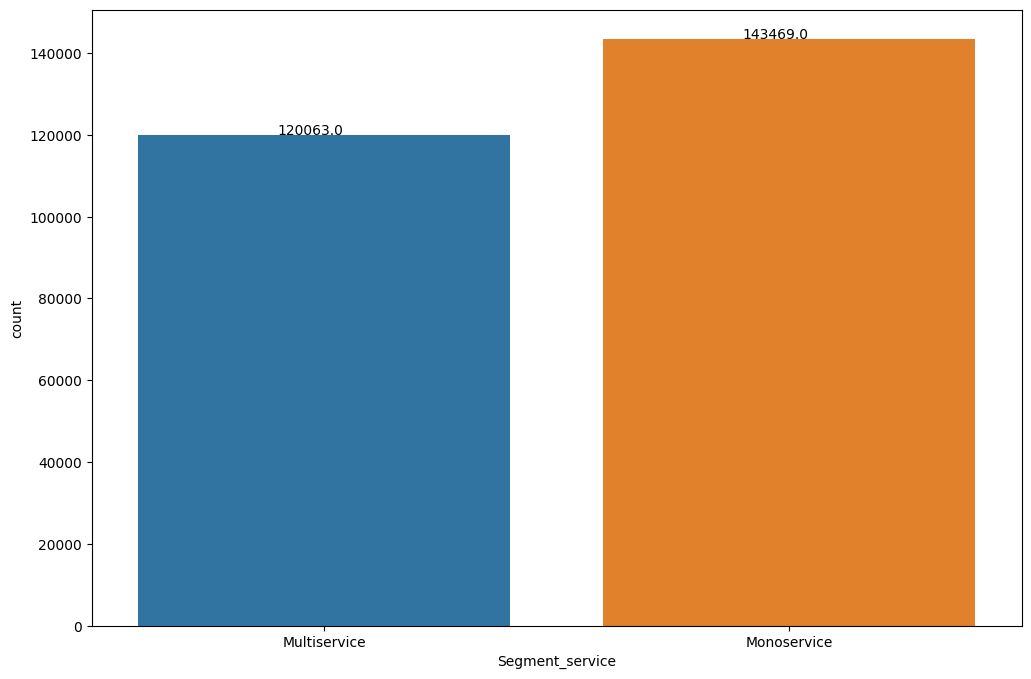

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# sns.histplot(df_rfm_fidelite["Fidelite"], color='steelblue', shrink=.8)
sns.countplot(x="Segment_service", data=pd_segment_multiservice)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

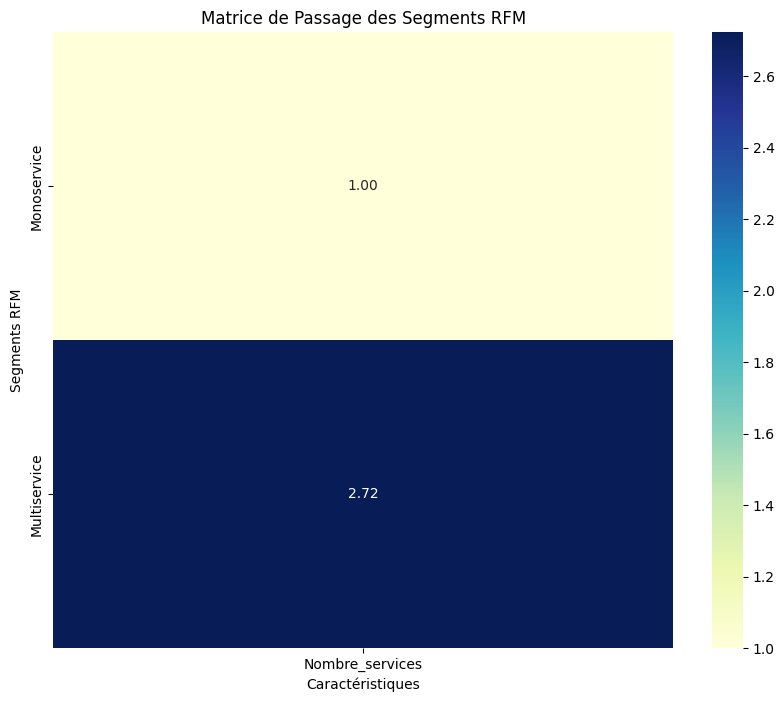

In [ ]:
import pandas as pd

# Supposons que vous avez un DataFrame "df" contenant les données

# Sélectionnez les colonnes pertinentes
selected_columns = ['Nombre_services','Segment_service']

# Créez un nouveau DataFrame contenant uniquement ces colonnes
df_selected = pd_segment_multiservice[selected_columns]

# Utilisez la fonction pivot_table pour créer la matrice de correspondance
matrix = pd.pivot_table(df_selected, index='Segment_service')
# Créez un heatmap pour représenter la matrice de passage
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu")

# Personnalisez le graphique
plt.title('Matrice de Passage des Segments RFM')
plt.xlabel('Caractéristiques')
plt.ylabel('Segments RFM')

# Affichez le graphique
plt.show()



# **MODÉLISATION POUR LA SEGMENTATION SELON LA VALEUR**

---



## **Méthode K-Means**

---





### Feature engineering

In [13]:
latest_date = to_date(lit("2023/08/17"), 'yyyy/MM/dd')
def df_kmeans_create(df_transaction: DataFrame, df_sico:DataFrame, df_segment_palier: DataFrame, df_segment_recharge :DataFrame,df_segment_multiservice:DataFrame) -> DataFrame:

    # Integration des donnés SICO
    taken_columns_sico = [ 'nd', 'date_naissance', 'date_debut_engagement', 'statut']
    df_sic = df_sico.select(taken_columns_sico) \
                    .filter(df_sico["statut"]=="ACTIF")  \
                    .filter(df_sico["date_naissance"] != "NULL")\
                    .withColumnRenamed("nd", "Numero") \
                    .drop("statut")
    df_sic= df_sic.withColumn("anciennete",  year(current_date()) - year("date_debut_engagement"))\
                  .withColumn("age", year(current_date()) - year("date_naissance")).drop("date_naissance")\
                  .filter(col("age")>0) \
                  .drop("date_debut_engagement")


    #Aggrégation des données de la Base_transaction préparées
    df_transaction_aggregated=df_transaction.groupBy("Numero")\
              .agg(datediff(latest_date,max(df_transaction["Date"]))\
              .alias("Recence"),count("*").alias("Frequence"),avg(df_transaction["Montant"]\
              .cast("double")).alias("Avg_chiffre_affaire")
       )

  #Integration des donnés de la segmentation palier
    taken_columns_palier=['msisdn','palier_inf','palier_sup']
    df_palier = df_segment_palier.select(taken_columns_palier) \
                  .withColumn("palier_inf", col("palier_inf").cast("double"))\
                  .withColumn("palier_sup", col("palier_sup").cast("double")) \
                  .withColumnRenamed("msisdn", "Numero")

    #Integration des donnés de la segmentation multiservice
    df_multiservice=df_segment_multiservice.drop("Segment_service")

    #Intégration des données de la segmentation recharge
    max_year_df_recharge = df_segment_recharge.agg({"year": "max"}).collect()[0][0]
    max_month_df_recharge = df_segment_recharge.filter(col("year") == max_year_df_recharge)\
            .agg({"month": "max"}).collect()[0][0]
    df_latest_segment_recharge = df_segment_recharge.withColumnRenamed("msisdn","Numero")\
                                  .withColumnRenamed("avg_montant_recharge","latest_avg_montant_recharge") \
                                  .filter((col("year") == max_year_df_recharge) & (col("month") == max_month_df_recharge)) \
                                  .select("Numero","latest_avg_montant_recharge") \
                                  .withColumn("latest_avg_montant_recharge", col("latest_avg_montant_recharge").cast("double"))

    #Jointure des Dataframes
    df_joined= df_sic.join(df_transaction_aggregated, "Numero", "inner")\
                      .join(df_palier,"Numero", "inner") \
                      .join(df_multiservice,"Numero", "inner")\
                      .join(df_latest_segment_recharge,"Numero", "inner")\
                      .drop("Services","Canaux")

    #Capitaliser les noms de colonnes
    uppercase_columns = [col(column_name).alias(column_name.capitalize()) for column_name in df_joined.columns]
    df_km_created= df_joined.select(*uppercase_columns)

    return df_km_created


In [14]:
def df_kmeans_encode(df_to_encode:DataFrame, categorical_columns: list):
    #Encodage des variables catégorielles
    # Initialiser les étapes pour le pipeline
    df_to_encode=df_to_encode
    etapes = []

    # Appliquer StringIndexer pour l'encodage des étiquettes
    for col in categorical_columns:
        indexer = StringIndexer(inputCol=col, outputCol=col + "Index")
        etapes.append(indexer)

    # Créer un pipeline
    pipeline = Pipeline(stages=etapes)

    # Ajuster et transformer le DataFrame à l'aide du pipeline
    model = pipeline.fit(df_to_encode)
    df_encoded = model.transform(df_to_encode)
    return df_encoded


In [15]:
df_kmeans_created=df_kmeans_create(df_transaction=df_transaction_prepared,df_sico=df_sico, df_segment_recharge=df_segment_recharge,df_segment_palier=df_segment_palier, df_segment_multiservice=df_segment_multiservice)

In [ ]:
df_kmeans_created.toPandas().describe()

,Anciennete,Age,Recence,Frequence,Avg_chiffre_affaire,Palier_inf,Palier_sup,Nombre_services,Nombre_canaux,Latest_avg_montant_recharge
count,53907.000000,53907.000000,53907.000000,53907.000000,5.390700e+04,5.390700e+04,5.390700e+04,53907.000000,53907.000000,5.390700e+04
mean,9.518467,39.549187,120.777803,6.056022,1.657853e+04,5.784090e+04,9.163433e+06,2.295583,1.429907,3.287175e+04
std,4.147295,15.496306,148.167788,7.332149,4.259027e+04,1.453826e+05,9.480203e+07,1.297451,0.556294,1.282583e+05
min,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000e+00,1.500000e+04,1.000000,1.000000,2.000000e+03
25%,7.000000,30.000000,8.000000,2.000000,2.666667e+03,0.000000e+00,1.500000e+04,1.000000,1.000000,8.000000e+03
50%,10.000000,37.000000,43.000000,4.000000,6.250000e+03,1.500000e+04,2.900000e+04,2.000000,1.000000,1.242267e+04
75%,15.000000,47.000000,181.000000,7.000000,1.512500e+04,5.000000e+04,8.000000e+04,3.000000,2.000000,2.201667e+04
max,15.000000,2020.000000,593.000000,490.000000,1.980000e+06,1.198000e+06,1.000000e+09,10.000000,4.000000,9.796743e+06


In [ ]:
df_info(df_kmeans_created)

root
 |-- Numero: string (nullable = true)
 |-- Anciennete: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Recence: integer (nullable = true)
 |-- Frequence: long (nullable = false)
 |-- Avg_chiffre_affaire: double (nullable = true)
 |-- Palier_inf: double (nullable = true)
 |-- Palier_sup: double (nullable = true)
 |-- Nombre_services: integer (nullable = false)
 |-- Nombre_canaux: integer (nullable = false)
 |-- Latest_avg_montant_recharge: double (nullable = true)

['Numero', 'Anciennete', 'Age', 'Recence', 'Frequence', 'Avg_chiffre_affaire', 'Palier_inf', 'Palier_sup', 'Nombre_services', 'Nombre_canaux', 'Latest_avg_montant_recharge']

 
  Nombre de lignes : 53907, Nombre de colonnes : 11
+-------+----------+---+-------+---------+-------------------+----------+----------+---------------+-------------+---------------------------+
|Numero |Anciennete|Age|Recence|Frequence|Avg_chiffre_affaire|Palier_inf|Palier_sup|Nombre_services|Nombre_canaux|Latest_avg_montant_re

In [ ]:
df_colonne_info(df_kmeans_created, "Statut")

 *****Informations sur la colonne ___Statut___: *****
Les valeurs distinctes sont:
+------+
|Statut|
+------+
|ACTIF |
+------+

Nombre de valeurs distinctes : 1
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


In [ ]:
df_kmeans_encoded=df_kmeans_encode(df_kmeans_created, categorical_columns=[])

### Nombre de clusters

In [ ]:
def elbow_method(df, feature_columns):
    # Assemble les caractéristiques en une seule colonne de vecteurs
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Essayer différentes valeurs de k et évaluer leur coût
    cost = []
    for k in range(2, 11):
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(df_kmeans)
        cost.append(model.summary.trainingCost)

    # Tracé du coût en fonction du nombre de clusters (méthode du coude)
    plt.plot(range(2, 11), cost, marker='o')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Coût')
    plt.title('Méthode du Coude pour le k optimal')
    plt.show()

# Exemple d'utilisation
feature_columns =[ 'Anciennete', 'Age', 'Recence', 'Frequence', 'Avg_chiffre_affaire', 'Palier_inf', 'Palier_sup', 'Nombre_services', 'Nombre_canaux', 'Latest_avg_montant_recharge']
elbow_method(df_kmeans_created, feature_columns)

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from pyspark.sql import DataFrame

def visualize_elbow(df: DataFrame):
    # Sélectionner les colonnes RFM pour l'analyse
    pd_kmeans = df.toPandas()
    kmeans_features = pd_kmeans[[ 'Anciennete', 'Age', 'Recence', 'Frequence', 'Avg_chiffre_affaire', 'Palier_inf', 'Palier_sup', 'Nombre_services', 'Nombre_canaux', 'Latest_avg_montant_recharge']]

    # Standardisation des caractéristiques
    scaler = StandardScaler()
    kmeans_features_scaled = scaler.fit_transform(kmeans_features)

    # Créer une instance du KElbowVisualizer
    visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1, 10))

    # Ajuster le modèle et le visualizer
    visualizer.fit(kmeans_features_scaled)

    # Afficher le graphique
    visualizer.show()

# Exemple d'utilisation
visualize_elbow(df_kmeans_created)

### Modèle

In [ ]:
def df_kmeans_model_train(df: DataFrame, optimal_k: int):
    feature_columns = ["Recence", "Frequence", "Montant_total", "Nombre_services", "Segment_serviceIndex"]
    # Assemble the features into a single vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Initialize the K-Means model
    kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")

    # Fit the K-Means model to the data
    model = kmeans.fit(df_kmeans)

    # Save the K-Means model to the specified path
    # model.write().overwrite().save(model_path)
    # return model

    # Effectue la transformation des données
    clustered_df = model.transform(df_kmeans)

    # Renomme la colonne "prediction" en "Cluster" et supprime la colonne "features"
    df_val_kmeans = clustered_df.withColumnRenamed("prediction", "Cluster").drop("features")

    return df_val_kmeans


In [ ]:
# df_kmeans_created = df_kmeans_create(df_om_prepared, ["Segment_service"])
df_segment_valeur_kmeans = df_kmeans_model_train(df=df_kmeans_created, optimal_k=4)

In [ ]:
df_segment_valeur_kmeans.show(2)

In [ ]:
from pyspark.ml.clustering import KMeans
def df_kmeans_modelTrainSave(df, feature_columns: list,  optimal_k: int, model_path: str):

    # Assemble the features into a single vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Initialize the K-Means model
    kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")

    # Fit the K-Means model to the data
    model = kmeans.fit(df_kmeans)

    # Save the K-Means model to the specified path
    model.write().overwrite().save(model_path)

    return model


In [ ]:
def df_kmeans_cluster(df, feature_columns, model_path):

    # Assemble les caractéristiques en une seule colonne de vecteurs
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Charge le modèle K-Means sauvegardé
    model = KMeansModel.load(model_path)

    # Effectue la transformation des données
    clustered_df = model.transform(df_kmeans)

    # Renomme la colonne "prediction" en "Cluster" et supprime la colonne "features"
    clustered_df = clustered_df.withColumnRenamed("prediction", "Cluster").drop("features")

    return clustered_df


In [ ]:
feature_columns =[ 'Anciennete', 'Age', 'Recence', 'Frequence', 'Avg_chiffre_affaire', 'Palier_inf', 'Palier_sup', 'Nombre_services', 'Nombre_canaux', 'Latest_avg_montant_recharge']
model_path = "#models_OM/model_OM_Kmeans"  # Chemin de sauvegarde du modèle
optimal_k = 3  # Nombre optimal de clusters
# df_kmeans_modelTrainSave(df_kmeans_created, feature_columns, optimal_k, model_path)

In [ ]:
df_kmeans = df_kmeans_cluster(df_kmeans_created, feature_columns, model_path)
df_info(df_kmeans)

root
 |-- Numero: string (nullable = true)
 |-- Anciennete: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Recence: integer (nullable = true)
 |-- Frequence: long (nullable = false)
 |-- Avg_chiffre_affaire: double (nullable = true)
 |-- Palier_inf: double (nullable = true)
 |-- Palier_sup: double (nullable = true)
 |-- Nombre_services: integer (nullable = false)
 |-- Nombre_canaux: integer (nullable = false)
 |-- Latest_avg_montant_recharge: double (nullable = true)
 |-- Cluster: integer (nullable = false)

['Numero', 'Anciennete', 'Age', 'Recence', 'Frequence', 'Avg_chiffre_affaire', 'Palier_inf', 'Palier_sup', 'Nombre_services', 'Nombre_canaux', 'Latest_avg_montant_recharge', 'Cluster']

 
  Nombre de lignes : 53907, Nombre de colonnes : 12
+-------+----------+---+-------+---------+-------------------+----------+----------+---------------+-------------+---------------------------+-------+
|Numero |Anciennete|Age|Recence|Frequence|Avg_chiffre_affaire|Palier_inf|Pa

### Visualisation des segments K-Means

In [ ]:
# Convertir le DataFrame Spark en DataFrame Pandas
pd_kmeans = df_kmeans.toPandas()

In [ ]:
# Convertir le DataFrame Spark en DataFrame Pandas
pd_kmeans = df_kmeans.toPandas()

# Définir la palette de couleurs
cluster_colors = ["green", "yellow", "red"]  # Vous pouvez personnaliser ces couleurs

# Créer le pairplot en utilisant la palette de couleurs
sns.set(style="ticks")
sns.pairplot(pd_kmeans, hue="Cluster", palette=cluster_colors)

# Afficher le pairplot
plt.show()

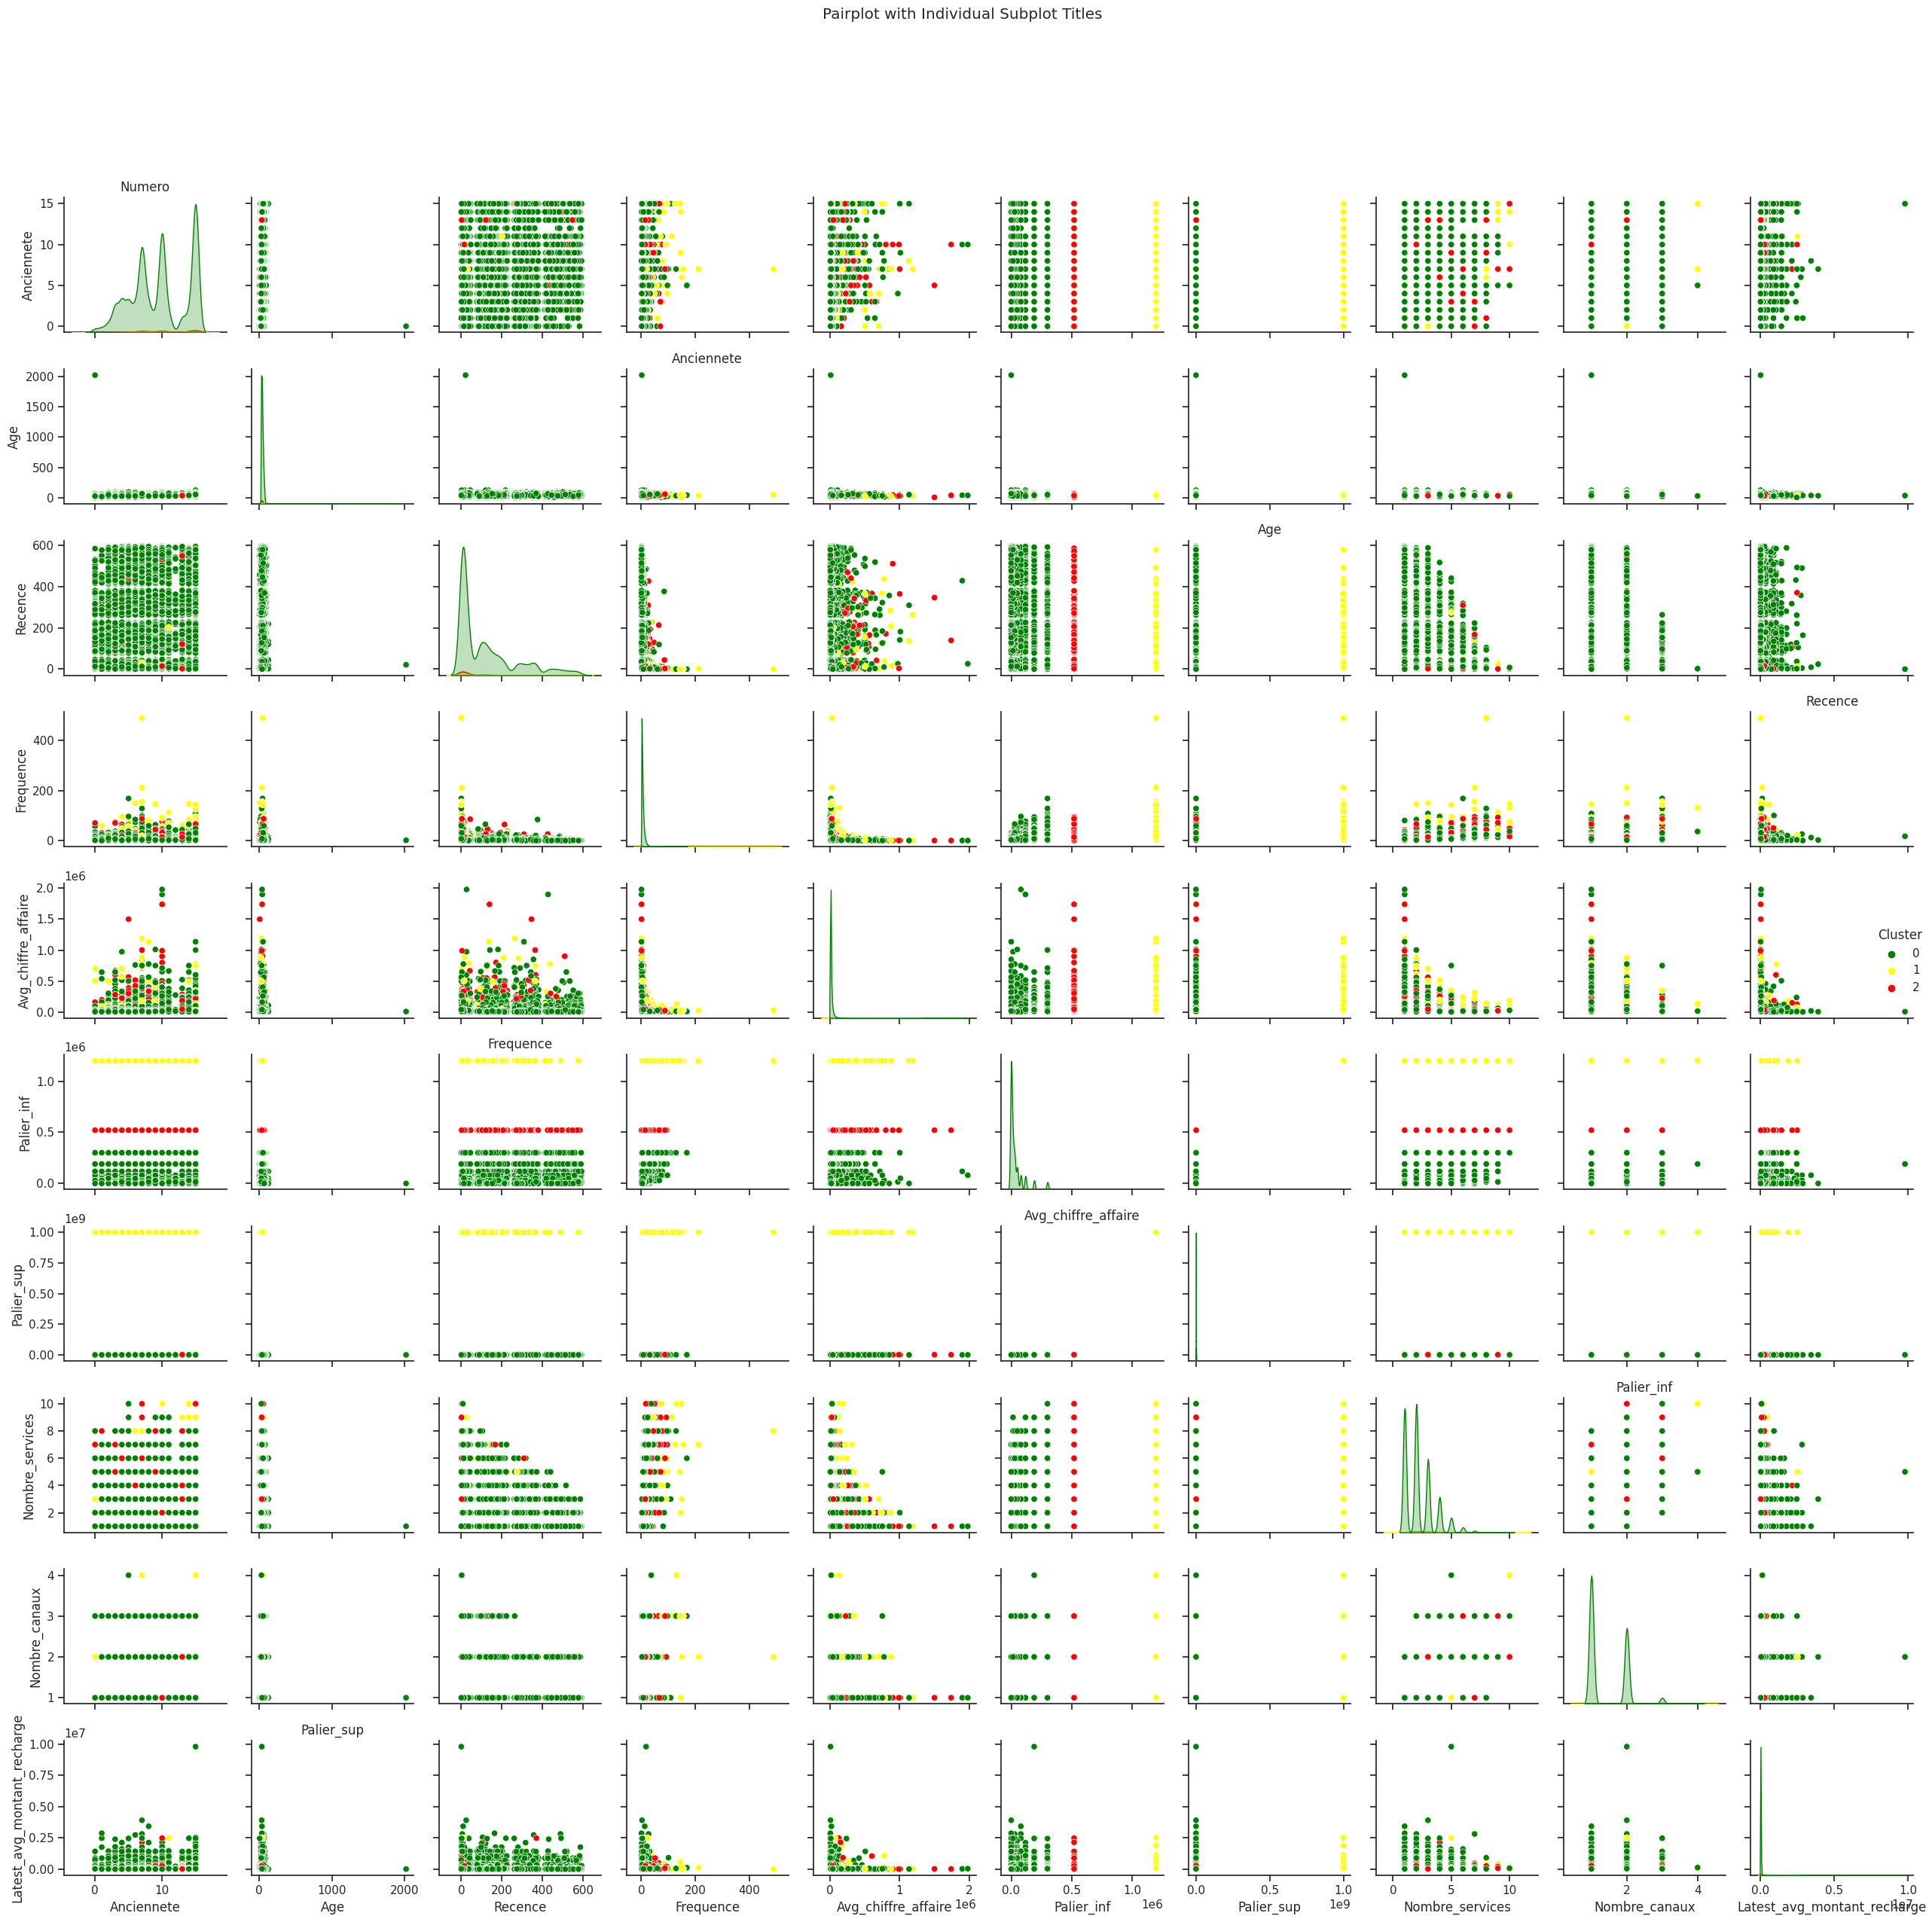

In [ ]:
# Define the color palette
cluster_colors = ["green", "yellow", "red"]  # Customize these colors

# Create the pairplot using the color palette
sns.set(style="ticks")
pairplot = sns.pairplot(pd_kmeans, hue="Cluster", palette=cluster_colors)

# Add an overall title to the pairplot
pairplot.fig.suptitle("Pairplot with Individual Subplot Titles", y=1.02)

# Add titles to each individual subplot
for i, ax in enumerate(pairplot.axes.flat):
    if i % (len(pd_kmeans.columns) + 1) == 0:
        ax.set_title(pd_kmeans.columns[i // (len(pd_kmeans.columns) + 1)])

# Adjust the layout for the titles
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the pairplot
plt.show()


In [ ]:
pal = ['gold','#cc0000', '#ace600','#33cccc']
plt.figure(figsize=(13,8))
pl = sns.countplot(x=pd_kmeans['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

### Profilage des segments

In [ ]:
# df_kmeans =  (df_kmeans
#     .withColumn('Segment',
#         when(col('Cluster')==0, lit('Very High'))
#         .when(col('Cluster')==1, lit('High'))
#         .when(col('Cluster')==2, lit('Medium'))
#          .when(col('Cluster')==3, lit('Low'))
#         .otherwise(lit('Autre'))
#     )
# )

# df_kmeans.filter(col("Segment_service")=="Medium").show()

## **Méthode RFM**

### Feature engineering

In [ ]:
latest_date = to_date(lit("2023/08/17"), 'yyyy/MM/dd')
def df_rfm_prepare(df):
    # Sélection des colonnes pertinentes pour RFM : Numero, Montant, Date
    df_rfm = df.select("Numero", "Montant", "Date")

    # Calcul de la date maximale dans le DataFrame
    max_date = df_rfm.agg(max("Date").alias("max_date")).collect()[0]["max_date"]

    # Convert the max_date string to a date object
    # latest_date = datetime.strptime(max_date, '%Y-%m-%d')

    # Calcul de la récence (Recency)
    df_recency = df_rfm.groupBy("Numero").agg(
        datediff(lit(latest_date), max(df["Date"])).alias("Recence")
    )

    # Calcul de la fréquence (Frequency, le nombre de transactions)
    df_frequency = df_rfm.groupBy("Numero").agg(
        count("*").alias("Frequence")
    )

    # Calcul de la valeur monétaire (Monetary Value, montant total des transactions)
    df_monetary = df_rfm.groupBy("Numero").agg(
        sum("Montant").alias("Montant")
    )

    # Jointure des DataFrames Recency, Frequency et Monetary
    df_rfm = df_recency.join(df_frequency, "Numero", "inner").join(df_monetary, "Numero", "inner")

    return df_rfm

In [ ]:
df_rfm_prepared=df_rfm_prepare(df_transaction_prepared)
pd_rfm_segments_prepared=df_rfm_prepared.toPandas()

### Calcul des scores

In [ ]:
def calculer_scores_rfm(df_rfm):
    # Calculer les quantiles pour les caractéristiques Recence, Frequence et Montant
    quantiles = df_rfm.approxQuantile(["Recence", "Frequence", "Montant"], [0.2, 0.4, 0.6, 0.8], 0.01)

    # Définir des expressions conditionnelles pour attribuer les scores R, F, et M
    df_rfm = (df_rfm
        .withColumn("R_Score",  when(df_rfm["Recence"] <= quantiles[0][0], lit(5))
                                .when(df_rfm["Recence"] <= quantiles[0][1], lit(4))
                                .when(df_rfm["Recence"] <= quantiles[0][2], lit(3))
                                .when(df_rfm["Recence"] <= quantiles[0][3], lit(2))
                                .otherwise(lit(1)))
        .withColumn("F_Score", when(df_rfm["Frequence"] >= quantiles[1][3], lit(5))
                                .when(df_rfm["Frequence"] >= quantiles[1][2], lit(4))
                                .when(df_rfm["Frequence"] >= quantiles[1][1], lit(3))
                                .when(df_rfm["Frequence"] >= quantiles[1][0], lit(2))
                                .otherwise(lit(1)))
        .withColumn("M_Score", when(df_rfm["Montant"] >= quantiles[2][3], lit(5))
                                .when(df_rfm["Montant"] >= quantiles[2][2], lit(4))
                                .when(df_rfm["Montant"] >= quantiles[2][1], lit(3))
                                .when(df_rfm["Montant"] >= quantiles[2][0], lit(2))
                                .otherwise(lit(1)))
                )
    df_rfm=df_rfm.withColumn("RFM_Score", concat(df_rfm["R_Score"].cast(StringType()), df_rfm["F_Score"].cast(StringType()), df_rfm["M_Score"].cast(StringType())))
    return df_rfm


### Profilage des segments

In [ ]:
def profiler_segments_rfm(df_rfm):
    segments = {
        'Champion': ['555', '554', '544', '545', '454', '455', '445'],
        'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
        'Fidèle potentiel': [
            '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
            '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
        ],
        'Prometteur': [
            '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
            '415', '315', '314', '313'
        ],
        'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
        'À risque': [
            '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
            '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
        ],
        'En sommeil': [
            '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
        ],
        'Sur le Point de Dormir': [
            '331', '321', '312', '221', '213', '231', '241', '251'
        ],
        # 'Engagés en sommeil': ["111", "112", "121", "131", "141", "151"],
        'Perdu': ['111', '112', '121', '131', '141', '151'],
        'Nouveau': ['512', '511', '422', '421', '412', '411', '311']
    }

    # Utiliser une expression conditionnelle pour attribuer les segments en fonction des scores RFM
    df_rfm = (df_rfm
        .withColumn('Segment_RFM',
            when(df_rfm['RFM_Score'].isin(segments['Champion']), lit('Champion'))
            .when(df_rfm['RFM_Score'].isin(segments['Fidèle']), lit('Fidèle'))
            .when(df_rfm['RFM_Score'].isin(segments['Fidèle potentiel']), lit('Fidèle potentiel'))
            .when(df_rfm['RFM_Score'].isin(segments['Nouveau']), lit('Nouveau'))
            .when(df_rfm['RFM_Score'].isin(segments['Prometteur']), lit('Prometteur'))
            .when(df_rfm['RFM_Score'].isin(segments['À surveiller']), lit('À surveiller'))
            .when(df_rfm['RFM_Score'].isin(segments['À risque']), lit('À risque'))
            .when(df_rfm['RFM_Score'].isin(segments['Sur le Point de Dormir']), lit('Sur le Point de Dormir'))
            .when(df_rfm['RFM_Score'].isin(segments['En sommeil']), lit('En sommeil'))
            # .when(df_rfm['RFM_Score'].isin(segments['Engagés en sommeil']), lit('Engagés en sommeil'))
            .when(df_rfm['RFM_Score'].isin(segments['Perdu']), lit('Perdu'))
            .otherwise(lit('Autre'))
        )
    )

    return df_rfm


### Test de la méthode RFM

In [ ]:
def segmenter_valeur_rfm(dataFrame: DataFrame):
  df_transformed=df_transform(dataFrame)
  df_transaction_prepared=df_clean(df_transformed)
  df_rfm=df_rfm_prepare(df_transaction_prepared)
  df_rfm_scores= calculer_scores_rfm(df_rfm)
  df_rfm_segments = profiler_segments_rfm(df_rfm_scores)
  return df_rfm_segments


In [ ]:
df_rfm_segments=segmenter_valeur_rfm(df_transaction_om)
df_rfm_segments.show()

+-------+-------+---------+--------+-------+-------+-------+---------+--------------------+
| Numero|Recence|Frequence| Montant|R_Score|F_Score|M_Score|RFM_Score|         Segment_RFM|
+-------+-------+---------+--------+-------+-------+-------+---------+--------------------+
|1000000|    167|        5| 68500.0|      3|      5|      5|      355|              Fidèle|
|1000001|     92|        5| 18150.0|      3|      5|      3|      353|    Fidèle potentiel|
|1000038|    123|        2|  6500.0|      3|      3|      2|      332|          En sommeil|
|1000048|      3|        4|105000.0|      5|      4|      5|      545|            Champion|
|1000054|    448|        1|  7000.0|      1|      2|      2|      122|          En sommeil|
| 100008|    179|        8|136100.0|      2|      5|      5|      255|            À risque|
|1000083|    476|        1|  1000.0|      1|      2|      1|      121|               Perdu|
| 100010|    538|        1|  1000.0|      1|      2|      1|      121|          

In [ ]:
def segment_client_rfm(numero):
  segment=df_rfm_segments.select("Numero","Segment_RFM").where(df_rfm_segments["Numero"]==numero).collect()[0][1]
  rfm_result={ "Client":numero,
       "Segment_RFM": segment}
  return rfm_result

In [ ]:
segment_client_rfm(1000038)

{'Client': 1000038, 'Segment_RFM': 'En sommeil'}

### Sauvegarde du DataFrame RFM

In [ ]:
#Save to csv
pd_rfm_segments=df_rfm_segments.toPandas()
pd_rfm_segments_sort =pd_rfm_segments.sort_values(["RFM_Score"])

In [ ]:
pd_rfm_segments.to_csv('#datasets_OM/base_transaction_om_rfm.csv', index=False)
# pd.read_csv('#datasets_OM/base_transaction_om_rfm.csv')

### Exploration du Dataframe RFM

In [ ]:
#Détails sur le dataframe RFM
df_info(df_rfm_segments)


########### Info ###########
root
 |-- Numero: string (nullable = true)
 |-- Recence: integer (nullable = true)
 |-- Frequence: long (nullable = false)
 |-- Montant: double (nullable = true)
 |-- R_Score: integer (nullable = false)
 |-- F_Score: integer (nullable = false)
 |-- M_Score: integer (nullable = false)
 |-- RFM_Score: string (nullable = false)
 |-- Segment: string (nullable = false)


########### Colonnes ###########
['Numero', 'Recence', 'Frequence', 'Montant', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Segment']

########### Dimensions ###########
Nombre de lignes : 263538, Nombre de colonnes : 9

########### Premières lignes ###########
+-------+-------+---------+--------+-------+-------+-------+---------+----------------+
|Numero |Recence|Frequence|Montant |R_Score|F_Score|M_Score|RFM_Score|Segment         |
+-------+-------+---------+--------+-------+-------+-------+---------+----------------+
|1000000|167    |5        |68500.0 |3      |5      |5      |355      |Fid

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Given data and segments
data = {
    'Champion': ['555', '554', '544', '545', '454', '455', '445'],
    'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Fidèle potentiel': [
        '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
        '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
    ],
    'Prometteur': [
        '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
        '415', '315', '314', '313'
    ],
    'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'À risque': [
        '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
        '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
    ],
    'En sommeil': [
        '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
    ],
    'Sur le Point de Dormir': [
        '331', '321', '312', '221', '213', '231', '241', '251'
    ],
    'Perdu': ['111', '112', '121', '131', '141', '151'],
    'Nouveau': ['512', '511', '422', '421', '412', '411', '311']
}

# Create a DataFrame with two columns: "Segment_RFM" and "RFM_Score"
df_segments_scores = None

for segment, scores in data.items():
    segment_df_segments_scores = spark.createDataFrame([(segment, score) for score in scores], ["Segment_RFM", "RFM_Score"])
    if df_segments_scores is None:
        df_segments_scores = segment_df_segments_scores
    else:
        df_segments_scores = df_segments_scores.union(segment_df_segments_scores)

# Assuming you have a DataFrame called df_segments_scores_rfm_segments
# First, group by the "Segment_RFM" column and collect the "RFM_score" values into a list
result_df_segments_scores = df_segments_scores.groupBy("Segment_RFM").agg(collect_set("RFM_score").alias("RFM_Scores"))

# Show the result DataFrame
result_df_segments_scores.toPandas()


,Segment_RFM,RFM_Scores
0,Champion,"[555, 545, 454, 544, 554, 455, 445]"
1,Fidèle,"[543, 355, 335, 354, 345, 344, 444, 435]"
2,Fidèle potentiel,"[551, 542, 352, 532, 452, 552, 533, 353, 441, 323, 423, 541, 432, 351, 442, 553, 433, 453, 431, 342, 341, 333, 531, 451]"
3,Prometteur,"[521, 514, 414, 413, 515, 314, 513, 315, 525, 425, 313, 415, 424, 524, 522, 523]"
4,À surveiller,"[443, 334, 434, 535, 343, 325, 324, 534]"
5,À risque,"[224, 244, 235, 242, 143, 134, 142, 254, 234, 152, 124, 255, 252, 135, 153, 133, 125, 253, 243, 245, 225, 145]"
6,En sommeil,"[223, 123, 322, 232, 132, 222, 212, 233, 122, 211, 332]"
7,Sur le Point de Dormir,"[331, 231, 213, 221, 312, 321, 251, 241]"
8,Perdu,"[111, 141, 112, 121, 131, 151]"
9,Nouveau,"[311, 421, 512, 511, 412, 411, 422]"


<Axes: xlabel='RFM_Score', ylabel='count'>

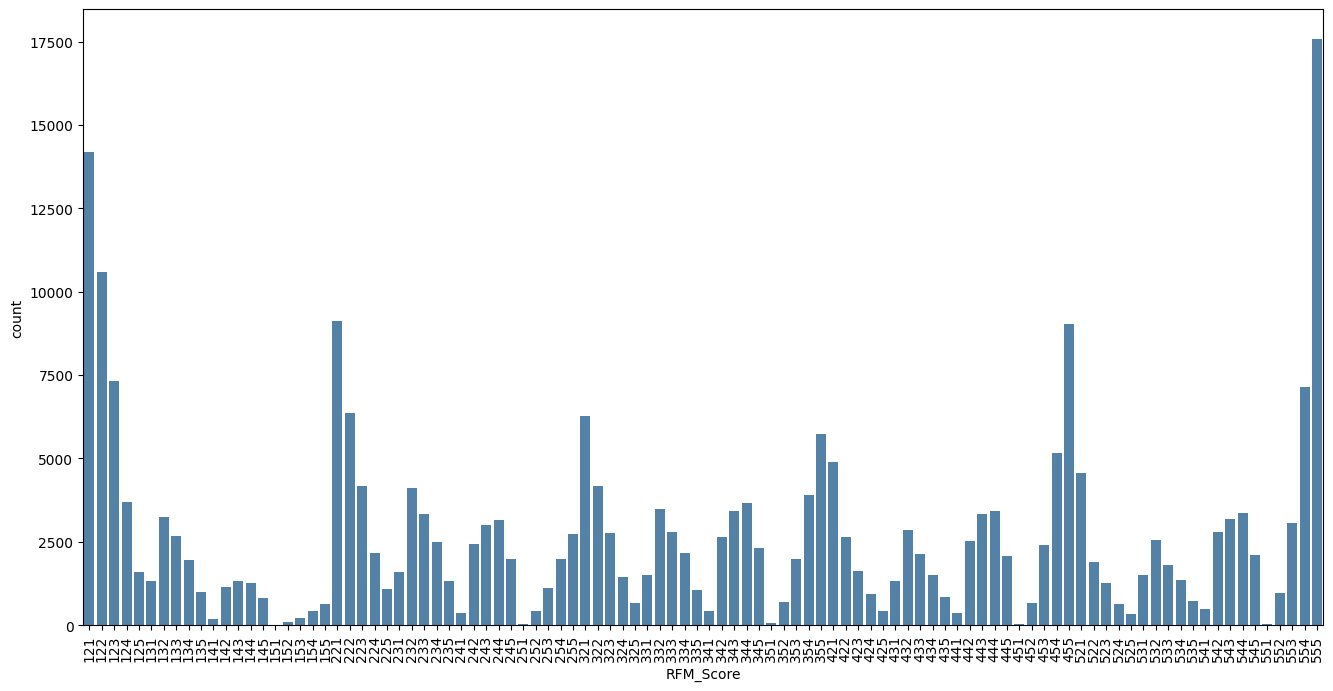

In [ ]:
# Inspect RFM


fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.xticks(rotation=90)
# sns.histplot(df_rfm_agg_scores["RFMScore"], kde=True, bins=10, ax=ax[0])
sns.countplot(x="RFM_Score", data=pd_rfm_segments_sort,
              color='steelblue')

# sns.histplot(df_rfm_agg_scores["RFMScoreGroup"], color='steelblue', ax=ax[2])

<Axes: xlabel='Montant', ylabel='Count'>

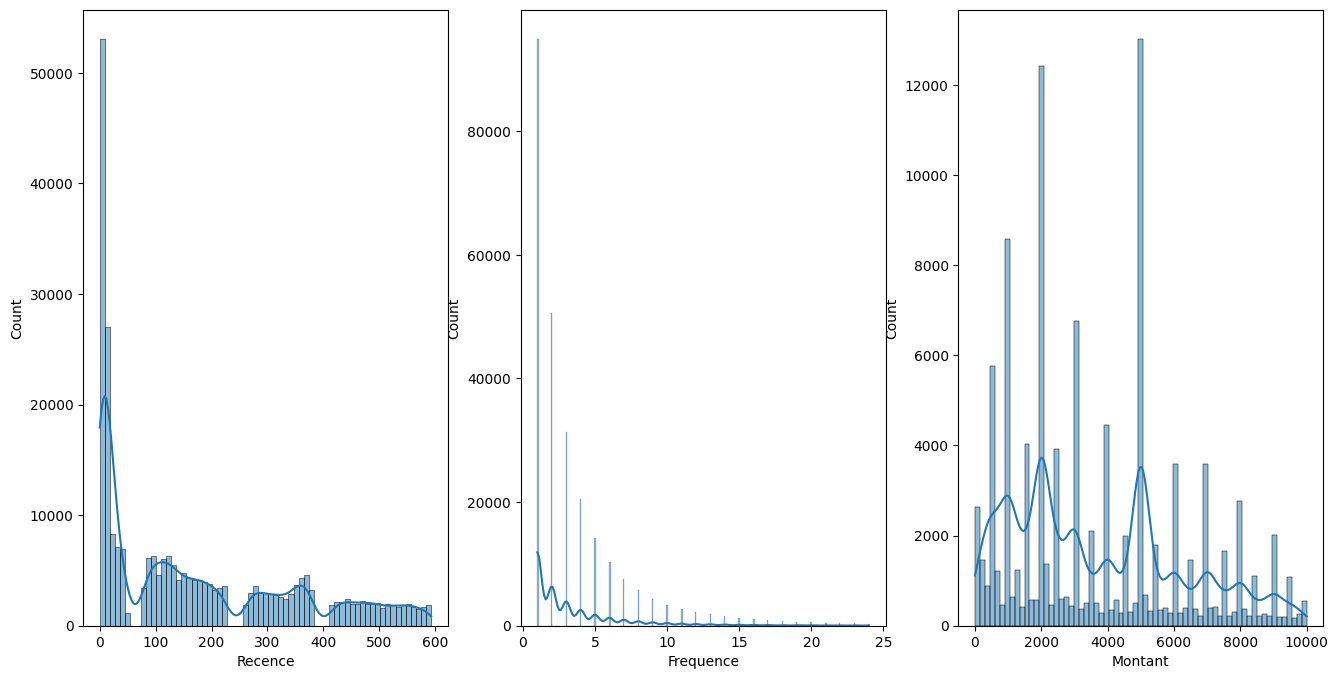

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(pd_rfm_segments['Recence'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(pd_rfm_segments.query('Frequence < 25')['Frequence'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(pd_rfm_segments.query('Montant < 10000')['Montant'], kde=True, ax=ax[2])

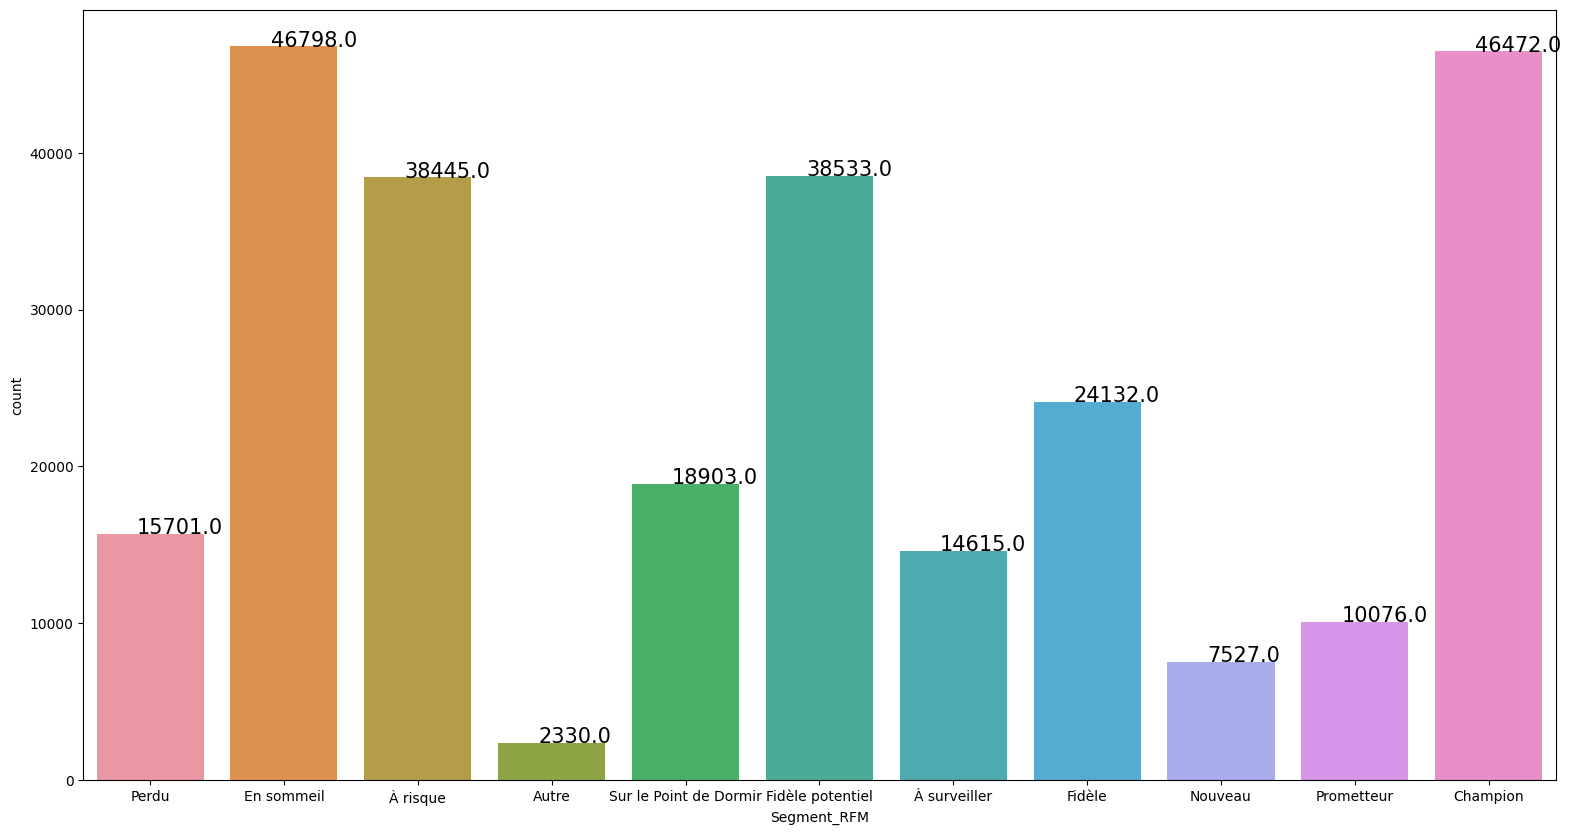

In [ ]:
# Assuming you have your data and plot settings ready

fig, ax = plt.subplots(1, 1, figsize=(19, 10))

# Create a countplot
sns.countplot(x="Segment_RFM", data=pd_rfm_segments_sort, ax=ax)

# Increase the font size of annotations
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1), fontsize=15)  # Adjust the fontsize as needed

# Show the plot
plt.show()


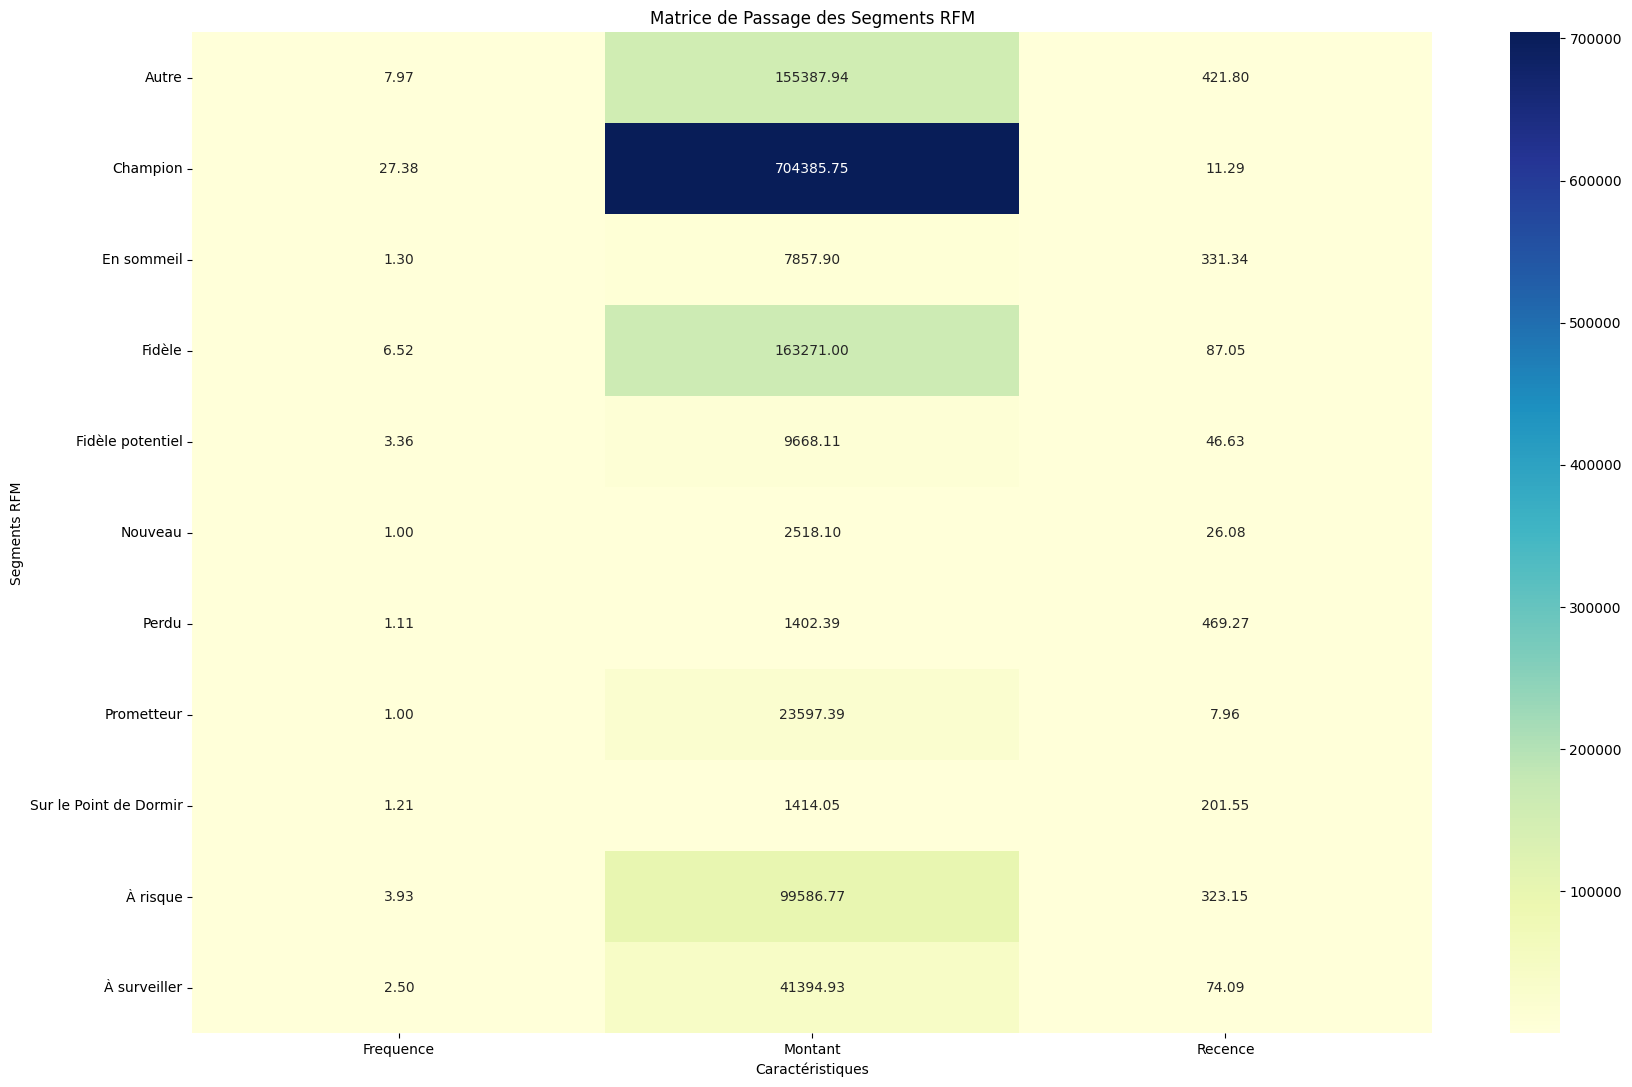

In [ ]:
import pandas as pd

# Supposons que vous avez un DataFrame "df" contenant les données

# Sélectionnez les colonnes pertinentes
selected_columns = ['Recence', 'Frequence', 'Montant', 'Segment_RFM']

# Créez un nouveau DataFrame contenant uniquement ces colonnes
df_selected = pd_rfm_segments[selected_columns]

# Utilisez la fonction pivot_table pour créer la matrice de correspondance
matrix = pd.pivot_table(df_selected, index='Segment_RFM')
# Créez un heatmap pour représenter la matrice de passage
plt.figure(figsize=(20, 13))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu")

# Personnalisez le graphique
plt.title('Matrice de Passage des Segments RFM')
plt.xlabel('Caractéristiques')
plt.ylabel('Segments RFM')

# Affichez le graphique
plt.show()



<Axes: xlabel='Montant', ylabel='Frequence'>

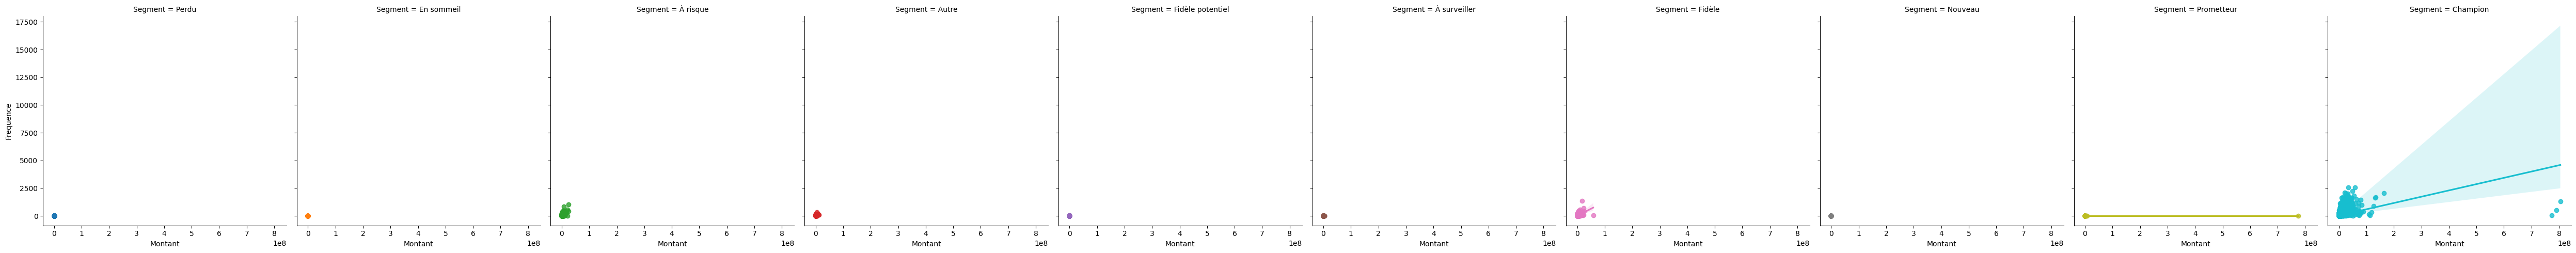

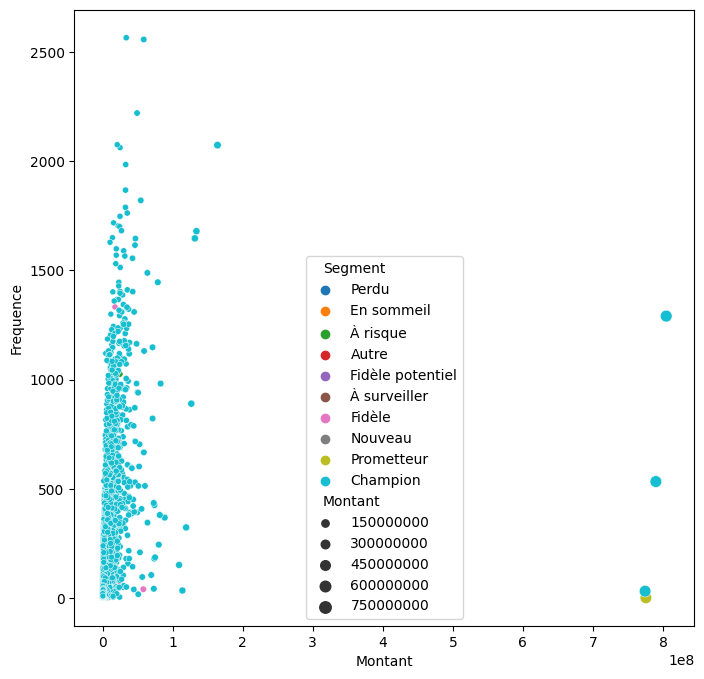

In [ ]:
# Monetary vs Frequency for each segment
sns.lmplot(x='Montant', y='Frequence', data=pd_rfm_segments_sort, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Montant', y='Frequence', data=pd_rfm_segments_sort, hue='Segment', size='Montant')

<Axes: xlabel='Recence', ylabel='Montant'>

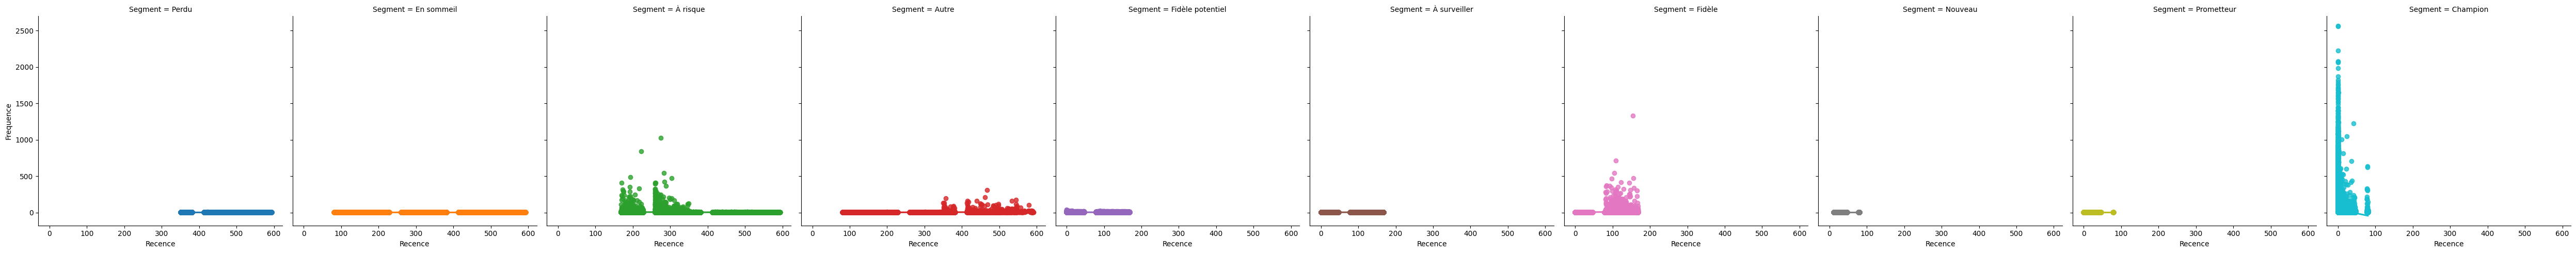

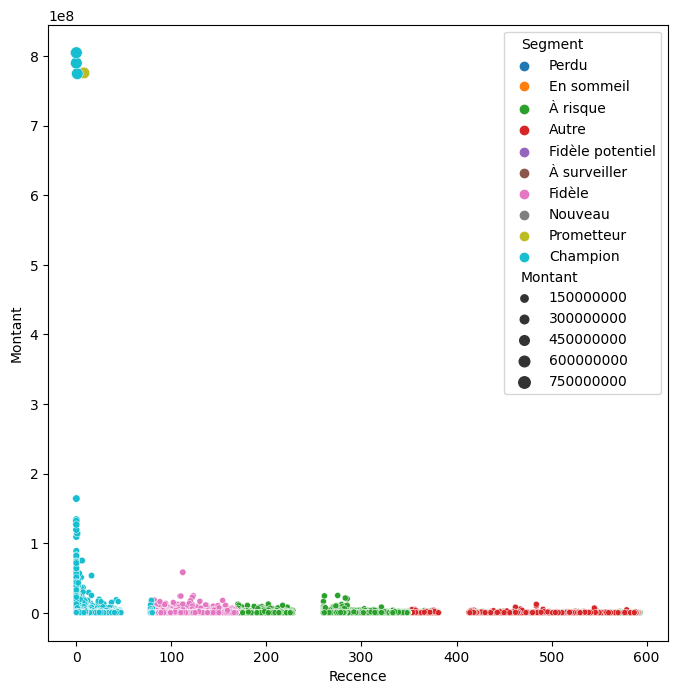

In [ ]:
# Recency vs Frequency for each segment
sns.lmplot(x='Recence', y='Frequence', data=pd_rfm_segments_sort, col='Segment', hue='Segment', fit_reg=True)

# Montant vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recence', y='Montant', data=pd_rfm_segments_sort, hue='Segment', size='Montant')

# **TESTS**

---



In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# # df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [ ]:
#!git clone https://github.com/asish012/dataanalytics.git